In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import sys
from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm

## 2. Multiple sequence alignment

! transeq seqdump.fasta > prot_sequence.fasta
! MAFFT prot_sequence.fasta > prot_alignment.fasta

In [2]:
# nucseq = open("seqdump.txt", "r")
# nucalign = []
# for line in prot_alignment:
#     line = line.split(" ")
#     nlist.append(line)
#     for i in nlist:
#         if ">" in i:
#             i = i + "_1"
#             nlist.append(i)
#             print(nlist)
#             print(i[0])
# for line in nlist: 
#     for i in line:
#         if ">" in i:
#             i = i + "_1"
#             print(nlist[0])
        


## 3. Converting back to nucleotides

In [3]:
class FASTAReader(object):

    def __init__(self, file):
        self.last_id = None
        self.file = file
        self.eof = False

    def __iter__(self):
        return self

    def __next__(self):
        if self.eof:
            raise StopIteration
        # check if this is the first sequence from the file
        if self.last_id is None:
            # First line
            line = self.file.readline()
            # Verify that this is a FASTA file
            assert line.startswith(">"), "Not a FASTA file"
            # Get the sequence ID
            seq_id = line[1:].rstrip("\r\n")
        else:
            # Get ID from previous round
            seq_id = self.last_id

        sequence = []
        while True:
            line = self.file.readline()
            # Check if we've reached the end of the file
            if line == "":
                self.eof = True
                break
            # Check if we've reached the next sequence
            elif not line.startswith(">"):
                sequence.append(line.strip())
            # We've reached the next sequence ID
            else:
                self.last_id = line[1:].rstrip("\r\n")
                break
        
        sequence = "".join(sequence)
        return seq_id, sequence




In [4]:
seq_dict = {}
aa_align = FASTAReader(open("prot_alignment.fasta")) # 
nuc_align = FASTAReader(open("seqdump.fasta"))
for seq_id,nuc_sequence in nuc_align:
    seq_id_split = seq_id.split()
    add_underscore = str(seq_id_split[0]) + '_1' # add _ to first element so it matches seq id
    seq_id_split[0] = add_underscore
    new_seq_id = ' '.join(seq_id_split)
    seq_dict.setdefault(new_seq_id,[nuc_sequence])
for seq_id,aa_sequence in aa_align:
    #print(seq_id)
    seq_dict[seq_id].append(aa_sequence)


In [5]:
for key, value in seq_dict.items():
    # Key = id, Value = [DNA,Amino Acids]
    count = 0
    res = list(value[0])
    for i in range(len(value[1])): # value[1] = amino acid seq
        #print(test_dic['X'][1][i])
        if value[1][i] == '-':
            res.insert((count), '---')
            res2 = ''.join(res)
            res = list(res2)
            #test_dic['X'][0] = res
        count = count+3
    value[0] = ''.join(res)

## 4. Looking for selection

In [6]:
query = seq_dict['NC_001563.2_1 West Nile virus lineage 2, complete genome']
nuc_ref = query[0]
aa_ref = query[1]

In [7]:
codontable = {
'ATA':'I', 'ATC':'I', 'ATT':'I', 'ATG':'M',
'ACA':'T', 'ACC':'T', 'ACG':'T', 'ACT':'T',
'AAC':'N', 'AAT':'N', 'AAA':'K', 'AAG':'K',
'AGC':'S', 'AGT':'S', 'AGA':'R', 'AGG':'R',
'CTA':'L', 'CTC':'L', 'CTG':'L', 'CTT':'L',
'CCA':'P', 'CCC':'P', 'CCG':'P', 'CCT':'P',
'CAC':'H', 'CAT':'H', 'CAA':'Q', 'CAG':'Q',
'CGA':'R', 'CGC':'R', 'CGG':'R', 'CGT':'R',
'GTA':'V', 'GTC':'V', 'GTG':'V', 'GTT':'V',
'GCA':'A', 'GCC':'A', 'GCG':'A', 'GCT':'A',
'GAC':'D', 'GAT':'D', 'GAA':'E', 'GAG':'E',
'GGA':'G', 'GGC':'G', 'GGG':'G', 'GGT':'G',
'TCA':'S', 'TCC':'S', 'TCG':'S', 'TCT':'S',
'TTC':'F', 'TTT':'F', 'TTA':'L', 'TTG':'L',
'TAC':'Y', 'TAT':'Y', 'TAA':'_', 'TAG':'_',
'TGC':'C', 'TGT':'C', 'TGA':'_', 'TGG':'W'
}

In [8]:
ds_vals = []
dn_vals = []
for i in range(0,len(nuc_ref),3): 
    if nuc_ref[i] == '-': # nuc_ref[i] = a 3 nuc codon
        continue
    else:
        dS = 0
        dN = 0
        for names, seqs in seq_dict.items():
            if nuc_ref[i:i+3] == seqs[0][i:i+3]:
                continue
            elif seqs[0][i:i+3] == '---':
                continue
            else: 
                if seqs[0][i:i+3] not in codontable:
                    #print(nuc_ref[i:i+3])
                    continue
                else:
                    if codontable[nuc_ref[i:i+3]] == codontable[seqs[0][i:i+3]]: 
                        dS+=1
                    else:
                        dN+=1
        ds_vals.append(dS)
        dn_vals.append(dN)

In [105]:
import pandas as pd 
df = pd.DataFrame(list(zip(dn_vals, ds_vals)), columns =['non', 'syn'])

In [150]:
# remove zeros
df2 = df.loc[df["syn"] != 0]
df3 = df2.loc[df["non"] != 0]
df3["ratio"] = df3['non']/df['syn']

In [151]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [ ]:
# pvalues_ratio = []
# for value in df3["dn_df"]:
#     z = (value-1)/(std/math.sqrt(3137))
#     p = stats.norm.sf(abs(z))
#     pvalues_ratio.append(p)
# # print(pvalues_ratio)
# #     pvalues.appstatsmodels.stats.weightstats.ztest(x1, x2=None, value=0, alternative='two-sided', usevar='pooled', ddof=1.0end(stats.norm.sf(abs(z)))

# df3["pvalues_ratio"] = pvalues_ratio

# # for value in df3["dn_df"]:
# #     print(value)

In [176]:
df3['Difference'] = df3["non"] - df3["syn"]
df3['mean'] = df3['Difference'].mean()
df3['stdev'] = df3['Difference'].std()
mean = df3['Difference'].mean()
std = df3['Difference'].std()
df3 = df3.drop("D", axis = 1)

,non,syn,ratio,mean,stdev,Difference,pvalues
0,146,33,4.424242,279.370736,256.331468,113,0.516242
1,47,7,6.714286,279.370736,256.331468,40,0.350313
2,185,7,26.428571,279.370736,256.331468,178,0.692451
3,197,2,98.500000,279.370736,256.331468,195,0.742005
5,200,7,28.571429,279.370736,256.331468,193,0.736115
9,211,34,6.205882,279.370736,256.331468,177,0.689575
10,217,2,108.500000,279.370736,256.331468,215,0.801688
12,372,4,93.000000,279.370736,256.331468,368,0.729481
15,413,9,45.888889,279.370736,256.331468,404,0.626768
16,391,81,4.827160,279.370736,256.331468,310,0.904871


In [143]:
# ratiosd = df3["dn_df"].std()
# zscores = []
# pvalues_ratio = []
# for value in df3["dn_df"]:
#     z = (value-1)/(ratiosd/math.sqrt(3137))
#     zscores.append(z)
#     p = stats.norm.sf(abs(z))
#     pvalues_ratio.append(p)
# df3["pvalues_ratio"] = pvalues_ratio

# negz = []
# for value in zscores: 
#     if value < 0: 
#         print(value)
        

In [ ]:
# for value in df3["dn_df"]:
#     z = (value-1)/(ratiosd/math.sqrt(3137))
#     zscores.append(z)
#     p = stats.norm.sf(abs(z))
#     pvalues_ratio.append(p)
# df3["pvalues_ratio"] = pvalues_ratio


In [164]:
# pvalues = []
# z = stats.zscore(df3["Difference"])
# for value in df3["Difference"]:
#     pvalues.append(stats.norm.sf(abs(z[value]))*2)
# df3["pvalues"] = pvalues

pvalues = []
z = stats.zscore(df3['Difference'])
for i in range(len(df3["Difference"])):
    pvalues.append(stats.norm.sf(abs(z[i]))*2)
df3["pvalues"] = pvalues

In [171]:
df3.shape

(3137, 8)

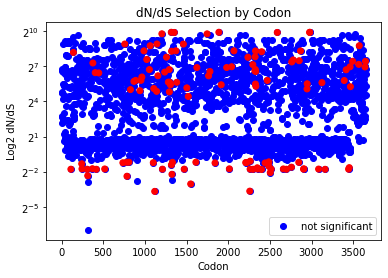

In [221]:
fig, ax = plt.subplots()
colors = ['r' if pval < 0.025 else 'none' for pval in df3['pvalues']]
ax.scatter(x = df3.index, y = df3['ratio'], color = 'blue')
ax.scatter(x = df3.index, y = df3['ratio'], color = colors)
ax.set_yscale('log', base=2)
plt.title('dN/dS Selection by Codon')
plt.xlabel('Codon')
plt.ylabel('Log2 dN/dS')
ax.legend(["not significant"])
plt.show()

/Users/cmdb/miniconda3/envs/cmdb/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':
No handles with labels found to put in legend.


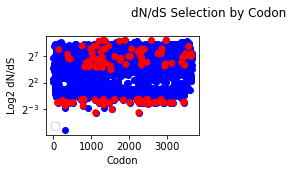

In [211]:
plt.figure()
plt.suptitle('dN/dS Selection by Codon')

plt.subplot(221)
colors = ['r' if pval < 0.025 else 'none' for pval in df3['pvalues']]
plt.scatter(x = df3.index, y = df3['ratio'], color = 'blue')
plt.yscale('log', base=2)

plt.subplot(221)
plt.scatter(x = df3.index, y = df3['ratio'], color = colors)

plt.yscale('log', base=2)

plt.xlabel('Codon')
plt.ylabel('Log2 dN/dS')
plt.legend()
plt.show()


In [63]:
import math
z = /(std/math.sqrt(3654))
np.around(stats.norm.sf(abs(z)), )
(x = df3.index, y = df3['ratio'], color = 'blue')
"{:e}".format(stats.norm.sf(abs(z)))

'0.000000e+00'

In [58]:
z = /(std/math.sqrt(3654))
np.around(stats.norm.sf(abs(z)), 10)

0.1378828352